In [292]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import re
import seaborn as sns
%matplotlib inline

In [293]:
charts = pd.read_csv('2019_top_100.csv')

In [294]:
charts

,artist,song,label,position,start_date,end_date
0,Capital Bra,Benzema,Universal Domestic Urban,1,28.12.2018,03.01.2019
1,Mariah Carey,All I Want For Christmas Is You,SME - Columbia,2,28.12.2018,03.01.2019
2,Wham!,Last Christmas,SME - Epic,3,28.12.2018,03.01.2019
3,Ava Max,Sweet But Psycho,Atlantic,4,28.12.2018,03.01.2019
4,Chris Rea,Driving Home For Christmas,Warner Music International,5,28.12.2018,03.01.2019
...,...,...,...,...,...,...
5295,Michael Bublé,Santa Claus Is Coming To Town,Reprise,96,27.12.2019,02.01.2020
5296,Apache 207,Sex mit dir,SME - Two Sides,97,27.12.2019,02.01.2020
5297,"The Cratez, Luciano & Kontra K",Himmel grau,SME - RBK,98,27.12.2019,02.01.2020
5298,The Kingdom Choir feat. Camélia Jordana & Namika,Holidays Are Coming,SME - Sony Music,99,27.12.2019,02.01.2020


In [295]:
charts['start_date']= pd.to_datetime(charts['start_date'], format='%d.%m.%Y')
charts['end_date']= pd.to_datetime(charts['end_date'], format='%d.%m.%Y')

In [296]:
charts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5300 entries, 0 to 5299
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   artist      5300 non-null   object        
 1   song        5300 non-null   object        
 2   label       5297 non-null   object        
 3   position    5300 non-null   int64         
 4   start_date  5300 non-null   datetime64[ns]
 5   end_date    5300 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 248.6+ KB


In [297]:
import datetime as dt

In [298]:
charts['week'] = charts['start_date'].dt.week

In [299]:
tracks = charts.song.unique()

peak_positions = charts.groupby(['song'])['position'].min()

for track in tracks:
    charts.loc[charts['song'] == track, 'peak'] = peak_positions[track]

In [300]:
charts.head()

,artist,song,label,position,start_date,end_date,week,peak
0,Capital Bra,Benzema,Universal Domestic Urban,1,2018-12-28,2019-01-03,52,1.0
1,Mariah Carey,All I Want For Christmas Is You,SME - Columbia,2,2018-12-28,2019-01-03,52,1.0
2,Wham!,Last Christmas,SME - Epic,3,2018-12-28,2019-01-03,52,2.0
3,Ava Max,Sweet But Psycho,Atlantic,4,2018-12-28,2019-01-03,52,1.0
4,Chris Rea,Driving Home For Christmas,Warner Music International,5,2018-12-28,2019-01-03,52,5.0


In [301]:
charts.columns

Index(['artist', 'song', 'label', 'position', 'start_date', 'end_date', 'week',
       'peak'],
      dtype='object')

In [302]:
counts = charts['artist'].value_counts().rename_axis('artist').reset_index(name='counts')
counts

,artist,counts
0,Apache 207,125
1,Capital Bra,119
2,Mero,93
3,Shindy,81
4,Billie Eilish,79
...,...,...
514,Jason Derulo x David Guetta feat. Nicki Minaj ...,1
515,K-Fly & MCN,1
516,Luis Fonsi feat. Daddy Yankee,1
517,Boney M.,1


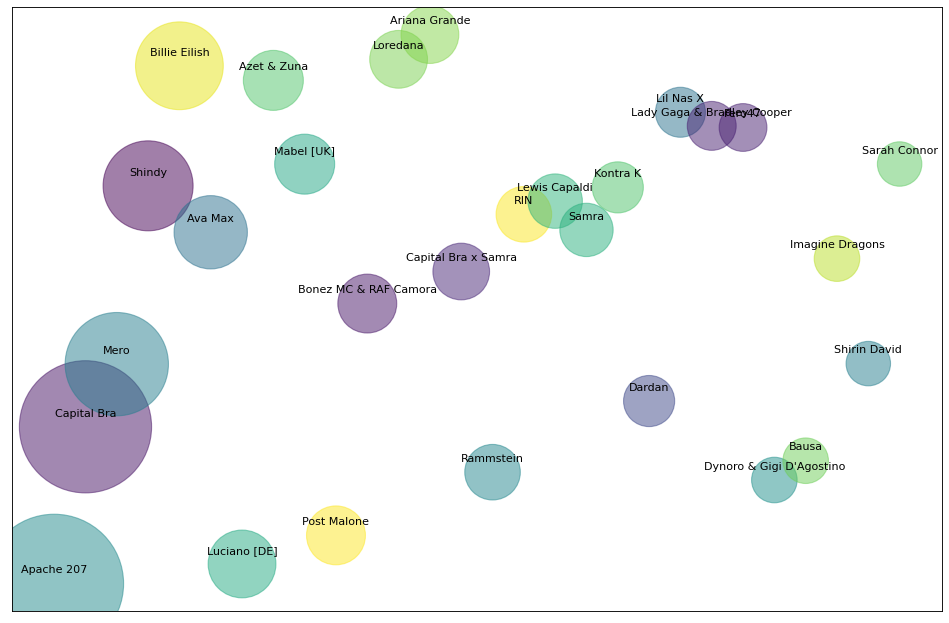

In [303]:
plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

top_artists = counts[counts['counts'] >= 40]

x = top_artists['artist']
y = np.random.rand(len(x))
#y_shuffled = np.random.shuffle(y)
colors = np.random.rand(len(x))
plt.scatter(x, y,
         marker='o', s=top_artists['counts']**2, alpha=.5, c=colors)

for i,j in zip(x,y):
    label = i
    
    # this method is called for each point
    plt.annotate(label, # this is the text
                 (i,j), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

plt.xticks([], [])
plt.yticks([], [])

plt.show()

In [304]:
def info_artist(artist_name):
    df = charts[charts['artist'] == artist_name].sort_values(by='start_date').copy()
    tracks = df.song.unique()
    plt.figure(figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')

    for track in tracks:
        x = df[df['song'] == track]['start_date']
        y = df[df['song'] == track]['position']
        plt.scatter(x, y,
                 marker='o', s=1000-y*10, alpha=.5,
                 label=track)

    plt.yticks(np.array([1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]))

    plt.legend(numpoints=1)

    ax = plt.gca()
    ax.invert_yaxis()

    plt.show()

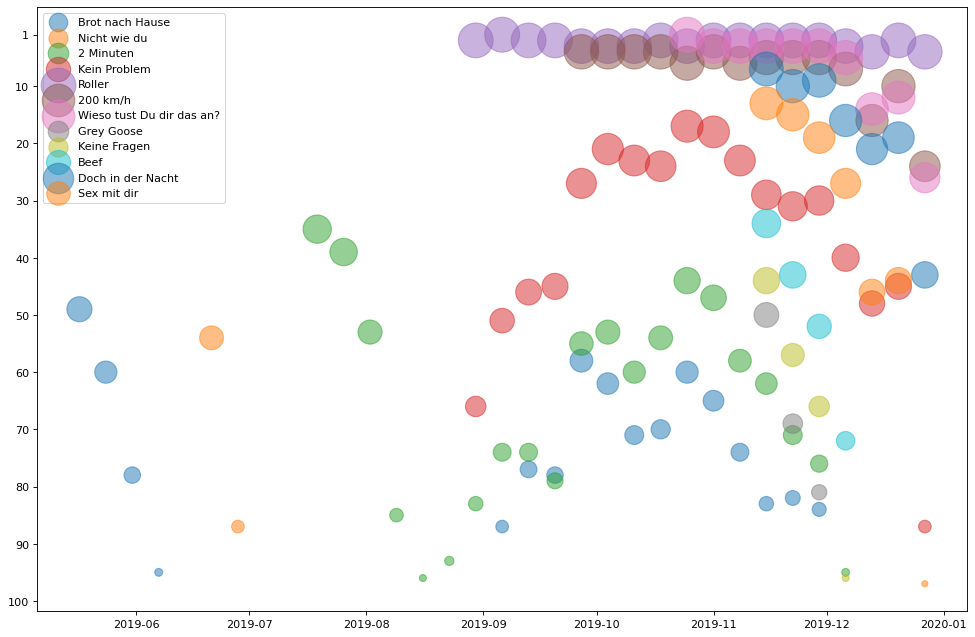

In [305]:
info_artist('Apache 207')

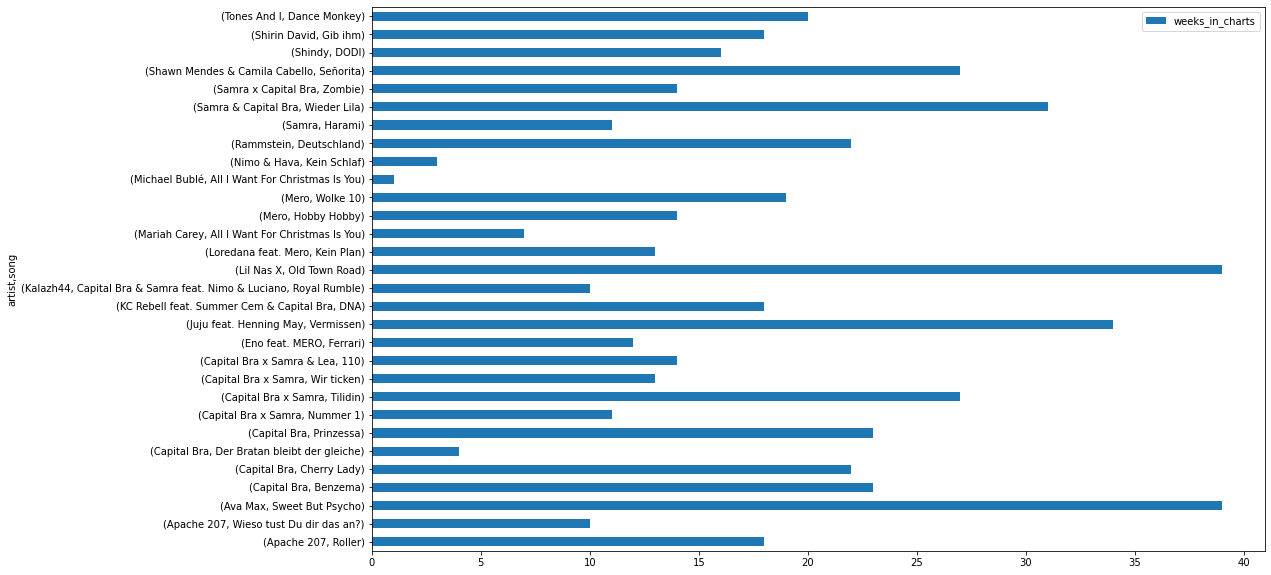

In [306]:
no_ones = charts['peak'] == 1

# number of weeks song was in Top100
weeks_charts = charts[no_ones].groupby(['artist', 'song']).count()[['week']]
weeks_charts.columns = ['weeks_in_charts']

weeks_charts.plot(kind='barh', figsize=(16,10))

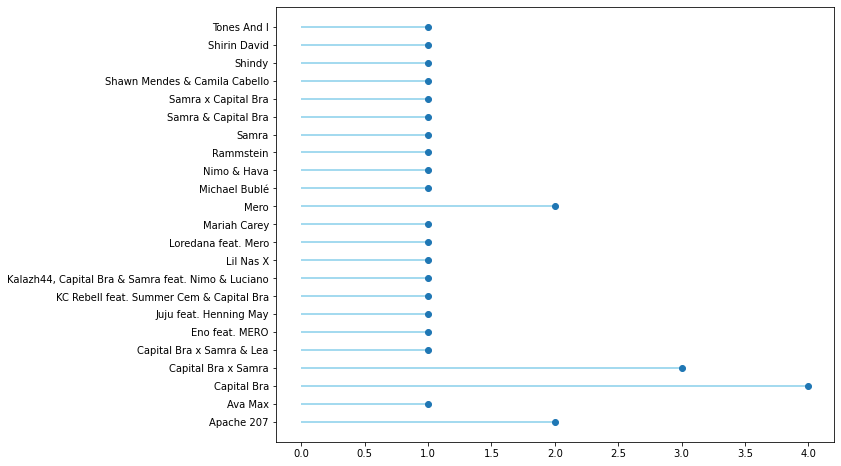

In [307]:
# find artists with most no.1 singles

fig = plt.figure(figsize=(10,8))

count = weeks_charts.groupby(['artist']).count()

plt.hlines(y=count.index, xmin=0, xmax=count, color='skyblue')
plt.plot(count, count.index, "o")


plt.show()

In [308]:
# extract individual artist from artist names

In [309]:
# extract words from song titles

words_in_title = [song.lower().split() for song in charts['song']]
words_in_title[:5]

[['benzema'],
 ['all', 'i', 'want', 'for', 'christmas', 'is', 'you'],
 ['last', 'christmas'],
 ['sweet', 'but', 'psycho'],
 ['driving', 'home', 'for', 'christmas']]

In [310]:
import itertools
import collections
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [311]:
# extract words from song titles

unique_titles = charts.song.str.replace('(','').str.replace(')', '').str.replace('?', '').str.replace('!', '').str.replace(',', '').unique()
words_in_title = [song.lower().split() for song in unique_titles]
words_in_title[:5]

[['benzema'],
 ['all', 'i', 'want', 'for', 'christmas', 'is', 'you'],
 ['last', 'christmas'],
 ['sweet', 'but', 'psycho'],
 ['driving', 'home', 'for', 'christmas']]

In [312]:
# List of all words across title
all_words = list(itertools.chain(*words_in_title))

# Create counter
count_words = collections.Counter(all_words)

# Remove stopwords
stop_words = set(stopwords.words(['english', 'german']))

# Add Christmas to stopword
stop_words.update(['christmas'])

titles_nsw = [[word for word in title_words if not word in stop_words]
              for title_words in words_in_title]

all_words = list(itertools.chain(*titles_nsw))

# count word without stopword
counts_nsw = collections.Counter(all_words)

# Top ten most used words
counts_nsw.most_common(10)

[('love', 12),
 ('like', 9),
 ('la', 6),
 ('let', 5),
 ('liebe', 5),
 ('remix', 5),
 ('bad', 5),
 ('sex', 5),
 ('money', 5),
 ('2', 5)]

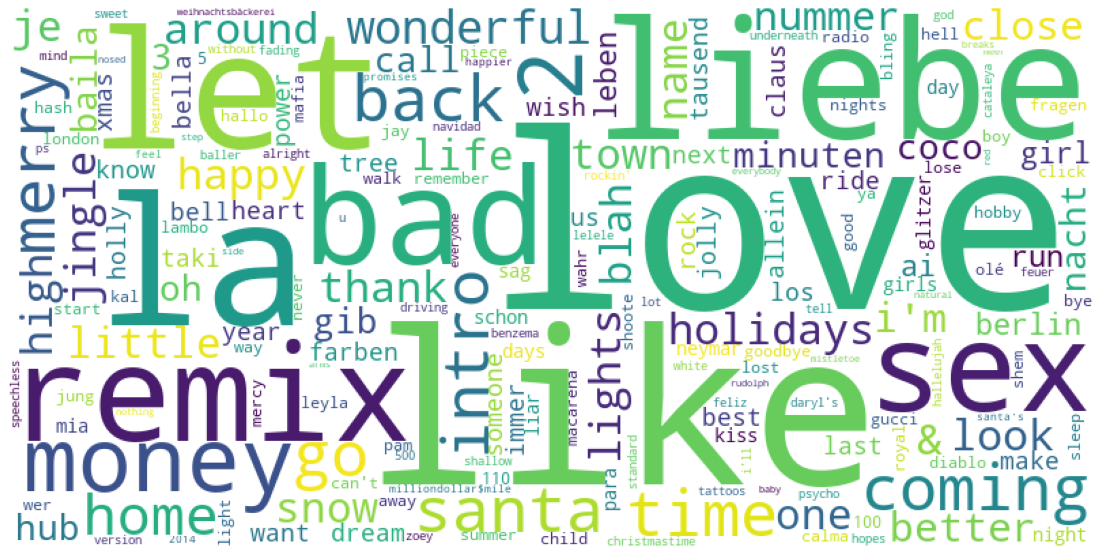

In [313]:
# Create and generate a word cloud image:
wordcloud = WordCloud(
                max_font_size=180,
                max_words=200,
                stopwords=stop_words,
                background_color="white",
                width=800,
                height=400
                ).fit_words(counts_nsw)

# Display the generated image:
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Uncomment to save image
#plt.savefig('wordcloud.png', facecolor='k', bbox_inches='tight')

# Save the image in the img folder:
#wordcloud.to_file("2019_titles.png")

In [314]:
charts[charts['song'].str.contains('Christmas')].groupby(['song']).max().sort_values(by='position', ascending=True)

,artist,label,position,start_date,end_date,week,peak
song,,,,,,,
Christmas Lights,Coldplay,Parlophone Label Group,44,2019-12-27,2020-01-02,52,38.0
Merry Christmas Everyone,Shakin' Stevens,SME - Epic,47,2019-12-27,2020-01-02,52,7.0
Have Yourself A Merry Little Christmas,Sam Smith,Capitol,52,2019-12-27,2020-01-02,52,41.0
Step Into Christmas,Elton John,Mercury,70,2019-12-27,2020-01-02,52,69.0
Wonderful Christmastime,Paul McCartney,Capitol,70,2019-12-27,2020-01-02,52,12.0
Like It's Christmas,Jonas Brothers,Jonas Brothers Recording,74,2019-12-27,2020-01-02,52,74.0
Holly Jolly Christmas,Michael Bublé,Reprise,77,2019-12-27,2020-01-02,52,69.0
"Merry Christmas, Happy Holidays",*N Sync,Sony Music,79,2019-12-27,2020-01-02,52,57.0
All I Want For Christmas Is You,Michael Bublé,SME - Columbia,80,2019-12-27,2020-01-02,52,1.0


In [315]:
charts[charts['song'].str.contains('[?]')].groupby(['song']).max().sort_values(by='position', ascending=True)

,artist,label,position,start_date,end_date,week,peak
song,,,,,,,
Wieso tust Du dir das an?,Apache 207,SME - Two Sides,26,2019-12-27,2020-01-02,52,1.0
Warum lügst du?,SSIO / Wanja Janeva,Alles Oder Nix Records,49,2019-12-13,2019-12-19,50,49.0
Do They Know It's Christmas?,Band Aid,Mercury,81,2019-12-27,2020-01-02,52,17.0
Wo???,Patron + Dardan,Hypnotize Entertainment,91,2019-11-08,2019-11-14,45,54.0
Do They Know It's Christmas? (2014),Band Aid 30,EMI,92,2019-12-27,2020-01-02,52,49.0
How Do You Sleep?,Sam Smith,Capitol,96,2019-11-15,2019-11-21,46,43.0
